# Supply exhaustion - Strategy - Backtesting 

### Import Library

In [82]:
import warnings
warnings.filterwarnings('ignore')
#
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
from stock_price_patterns.candlestick import CandlestickPatterns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

### Load Price Data

In [83]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [84]:
data = dataset.copy()

In [85]:
data = data[data.index > '2020-11-01 00:00:00']
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
# data = data[data.index > '2024-11-01 00:00:00']

In [86]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-10-30 14:10:00,1916.0,1925.4,1915.3,1922.5,13042
2025-10-30 14:15:00,1922.6,1923.0,1910.5,1918.6,16670
2025-10-30 14:20:00,1917.7,1925.0,1915.0,1917.4,12613


In [87]:
import pandas as pd

def has_long_signal(r):
    try:
        return (
            r["color"] == "black" and
            r["color_prev"] == "black" and
            r["body"] <= 2 and
            r["body_prev"] <= 2 and
            r["min6"] < r["min3"] and
            r["Volume"] < 0.65 * r["avg_volume_20"] and
            r["Volume_prev"] < 0.75 * r["avg_volume_20"]
        )
    except Exception:
        return False


def prepare_data(df):
    df['body'] = abs(df['Close'] - df['Open'])
    df['min6'] = df['Low'].rolling(6).min()
    df['min3'] = df['Low'].rolling(3).min()
    df['avg_volume_20'] = df['Volume'].rolling(20).mean()

    df['color'] = df.apply(lambda r: "black" if r["Close"] < r["Open"] else "white", axis=1)
    df['color_prev'] = df['color'].shift(1)
    df['body_prev'] = df['body'].shift(1)
    df['Volume_prev'] = df['Volume'].shift(1)

    df['signal'] = df.apply(lambda r: 'long' if has_long_signal(r) else '', axis=1)
    return df

In [88]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [89]:
prepared_data[prepared_data.signal == 'long']

,Open,High,Low,Close,Volume,body,min6,min3,avg_volume_20,color,color_prev,body_prev,Volume_prev,signal
Date,,,,,,,,,,,,,,
2020-11-03 09:15:00,908.6,908.9,908.3,908.5,1355,0.1,904.0,908.2,3452.50,black,black,0.2,1159.0,long
2020-11-09 09:30:00,915.8,916.2,915.5,915.5,1430,0.3,914.4,915.3,2840.25,black,black,0.3,924.0,long
2020-11-12 10:10:00,925.3,925.7,924.9,925.0,1532,0.3,923.5,924.8,2775.30,black,black,0.7,1612.0,long
2020-11-13 09:35:00,928.3,928.5,927.9,927.9,1203,0.4,926.5,927.9,2809.75,black,black,0.6,980.0,long
2020-11-13 10:00:00,928.6,928.6,928.3,928.4,783,0.2,927.9,928.1,2385.00,black,black,0.3,1070.0,long
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-16 11:15:00,2017.9,2018.0,2016.7,2017.2,1585,0.7,2016.6,2016.7,3450.70,black,black,1.1,1484.0,long
2025-10-21 10:25:00,1893.8,1895.6,1892.0,1892.7,3548,1.1,1891.0,1891.1,8812.00,black,black,7.8,5989.0,long
2025-10-23 10:10:00,1930.3,1934.1,1928.2,1929.5,5631,0.8,1916.2,1928.2,9760.15,black,black,2.7,5138.0,long


In [90]:
class MainStrategy(Strategy):
    SL = 5.2
    RR = 3
    def init(self):
        self._broker._cash = 3500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long:
                self.position.close()
            return

        if self.position:
            return 
        signal = self.data.signal[-1]
        close_price = self.data.Close[-1]
        open_price = self.data.Open[-1]
        if signal == 'long':
            buy_price = close_price
            sl = buy_price - self.SL
            tp = buy_price + self.SL * self.RR
            self.buy(size=1, sl=sl, tp=tp)

In [91]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [92]:
stats

Start                     2020-11-02 09:05:00
End                       2025-10-30 14:45:00
Duration                   1823 days 05:40:00
Exposure Time [%]                    22.00227
Equity Final [$]                   3293.63775
Equity Peak [$]                     3585.2616
Commissions [$]                     418.86225
Return [%]                           -5.89606
Buy & Hold Return [%]               114.25395
Return (Ann.) [%]                    -1.22057
Volatility (Ann.) [%]                 2.17163
CAGR [%]                             -0.83642
Sharpe Ratio                         -0.56205
Sortino Ratio                         -0.8945
Calmar Ratio                         -0.11555
Alpha [%]                            -8.93624
Beta                                  0.02661
Max. Drawdown [%]                   -10.56269
Avg. Drawdown [%]                    -0.33156
Max. Drawdown Duration     1592 days 04:30:00
Avg. Drawdown Duration       36 days 20:49:00
# Trades                          

In [93]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,SL,TP,PnL,Commission,ReturnPct,EntryTime,ExitTime,Duration,Tag
0,1,54,99,908.5,909.0,903.3,924.1,-0.04525,0.54525,-0.000050,2020-11-03 09:20:00,2020-11-03 14:30:00,0 days 05:10:00,None
1,1,261,303,915.5,921.9,910.3,931.1,5.84878,0.55122,0.006389,2020-11-09 09:35:00,2020-11-09 14:30:00,0 days 04:55:00,None
2,1,422,456,924.9,926.5,919.8,940.6,1.04458,0.55542,0.001129,2020-11-12 10:15:00,2020-11-12 14:30:00,0 days 04:15:00,None
3,1,464,505,928.0,935.8,922.7,943.5,7.24086,0.55914,0.007803,2020-11-13 09:40:00,2020-11-13 14:30:00,0 days 04:50:00,None
4,1,561,606,919.2,934.7,913.9,934.7,14.94383,0.55617,0.016257,2020-11-17 09:15:00,2020-11-17 14:25:00,0 days 05:10:00,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,1,62787,62801,2017.0,2012.0,2012.0,2032.8,-6.20870,1.20870,-0.003078,2025-10-16 11:20:00,2025-10-16 14:00:00,0 days 02:40:00,None
533,1,62924,62924,1892.7,1887.5,1887.5,1908.3,-6.33406,1.13406,-0.003347,2025-10-21 10:30:00,2025-10-21 10:30:00,0 days 00:00:00,None
534,1,63019,63021,1929.5,1924.3,1924.3,1945.1,-6.35614,1.15614,-0.003294,2025-10-23 10:15:00,2025-10-23 10:25:00,0 days 00:10:00,None
535,1,63112,63112,1942.6,1937.6,1937.6,1958.4,-6.16406,1.16406,-0.003173,2025-10-27 09:50:00,2025-10-27 09:50:00,0 days 00:00:00,None


In [94]:
prepared_data[(prepared_data.index >= '2025-10-29 09:00:00') & (prepared_data.index <= '2025-10-29 15:00:00')]

,Open,High,Low,Close,Volume,body,min6,min3,avg_volume_20,color,color_prev,body_prev,Volume_prev,signal
Date,,,,,,,,,,,,,,
2025-10-29 09:00:00,1943.8,1947.0,1942.2,1943.0,6789,0.8,1906.0,1926.5,11124.00,black,white,0.0,6701.0,
2025-10-29 09:05:00,1943.0,1945.0,1942.5,1944.7,3049,1.7,1908.6,1940.9,10829.30,white,black,0.8,6789.0,
2025-10-29 09:10:00,1944.6,1944.8,1942.0,1942.0,1992,2.6,1925.7,1942.0,10518.30,black,white,1.7,3049.0,
2025-10-29 09:15:00,1942.0,1942.8,1938.6,1940.8,6111,1.2,1926.5,1938.6,10537.50,black,black,2.6,1992.0,long
2025-10-29 09:20:00,1941.0,1941.0,1937.7,1940.3,4149,0.7,1937.7,1937.7,9884.65,black,black,1.2,6111.0,
2025-10-29 09:25:00,1940.3,1943.6,1940.0,1943.1,4096,2.8,1937.7,1937.7,9545.65,white,black,0.7,4149.0,
2025-10-29 09:30:00,1943.5,1944.8,1942.0,1942.0,4470,1.5,1937.7,1937.7,9198.25,black,white,2.8,4096.0,
2025-10-29 09:35:00,1942.0,1942.1,1936.1,1941.3,6463,0.7,1936.1,1936.1,8965.75,black,black,1.5,4470.0,
2025-10-29 09:40:00,1941.3,1945.8,1940.5,1944.3,4738,3.0,1936.1,1936.1,8632.60,white,black,0.7,6463.0,


In [95]:
# bt.plot()

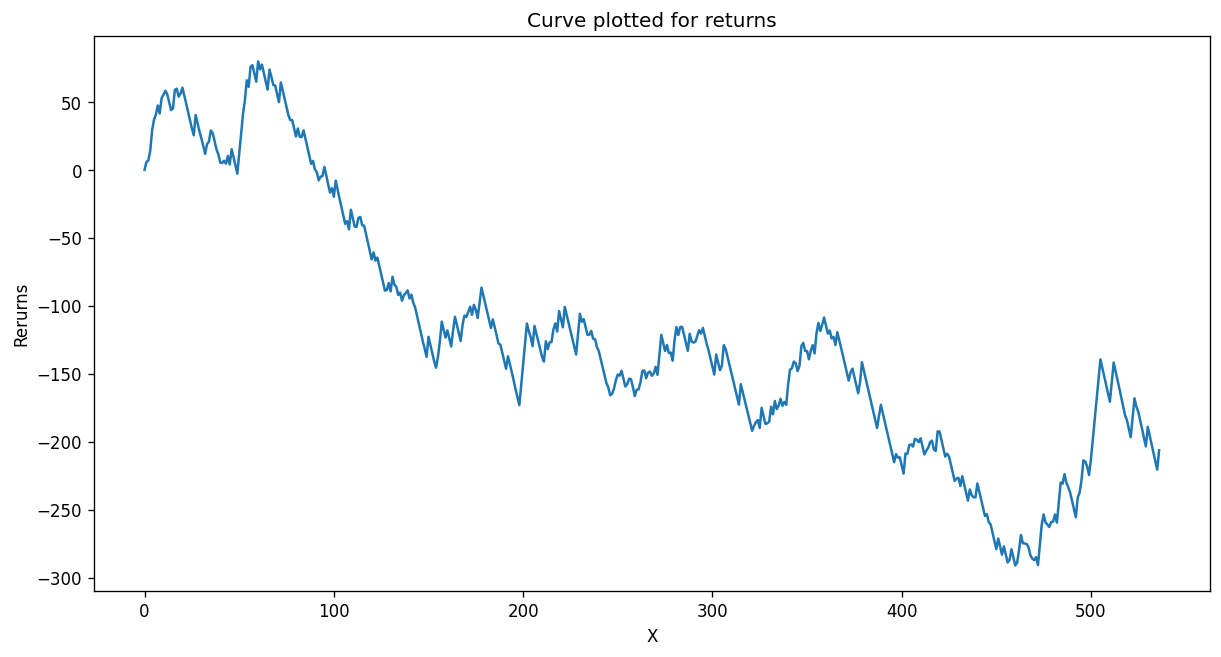

In [96]:
copy_trades = stats['_trades'].copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()